## Abstract

The aim of this report is to build an Expected Threat (xT) Model and illustrate how it can be applied to evaluate performance of players that play from the deeper zones, mainly participate in the game build-up and can be overlooked by the traditional statistics like goals or assists or more advanced ones like Expected Goals (xG) or Expected Assists (xA).

## Introduction

Goals and assists are traditional statistics in soccer which focus on player's shooting and creative capabilities. They concentrate on the assessment of only goal-oriented skills of the player. However, there can be play sequences in soccer that do not end with shots and sometimes lack a final accurate pass or touch that could have put another player into a shooting position. In such circumstances, the evaluation of the game build-up is still important. The actions of players who generate these kind of situations on field should be quantifiable to understand the threatening degree of those situations, and see if a player could have made a better decision. Quantification of these actions can also help to assess impact of players who participate in the game build-up and do not often find themselves close to the opponent's goal.

There are advanced metrics for the evaluation of players that participate in the game build-up such as **xGChain** and **xGBuildup**. However, the problem with these metrics is that the xG value of a resulting shot is divided equally among all participants involved in a play sequence (in case of xGBuildup, all players, except assisting and sh0oting ones, are included). These metrics also fail to capture non-shot ending game scenarios.

It is worth mentioning that there are also other well known models (Posession Value Framework, VAEP etc.) which can be used as alternatives to xT model and are widely implemented in soccer analytics today.

This report illustrates a simple implementation of xT model that accounts only for passes that increase team's probability of scoring. Considering that each pass has an impact on team's probability of scoring, we are able to evaluate how threatining is the pass and assign it a certain value.

This model was originally introduced by [Karun Singh](https://karun.in/blog/expected-threat.html) in his blog post from 2019. Despite being written as a blog post, it gained a strong recognition from the soccer analytics community and was cited in different research papers. A grop of researchers from DTAI Sports Analytics Lab at KU Leuven University published a [paper](https://tomdecroos.github.io/reports/xt_vs_vaep.pdf) where they were comparing xT Model to VAEP framework.

## Algorithm

xT model represents a soccer pitch as a `12 x 16 grid` where each section of a grid has an assigned xT value. This value is defined as `a probability of a team scoring within n next actions`. When a player passes from $(x_{start}, y_{start})$ to $(x_{end}, y_{end})$ coordinate, a completed pass generates so called `xT difference` that allows to quantify its impact and understand how a team's probability of scoring changes.  

Below you can see xT grid that was calculated in the course of this report. Here, each zone of the grid contains a value that implies a team's probability of scoring in `5` next actions. One may consider higher/lower number of actions but the important point is to observe convergence of xT values in the attacking area, and increasing probability the defending area. More actions would mean that a team can spend more time preparing an attack and gradually progressing further which results into a greater probability of scoring when starting from its own half.  

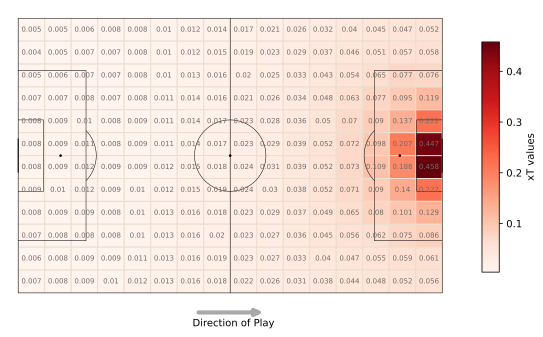

In [490]:
plot_xT()

To calculate xT value for each coordinate (x, y) on the pitch, the following equation is used:

\begin{equation}
xT_{x,y} = s_{x,y}\cdot xG_{x,y} + m_{x, y} \cdot T_{x,y} \cdot xT
\end{equation}

where  
$xT_{x,y}$ - xT value for (x, y) coordinate  

$s_{x,y}$ - probability of shooting from (x, y) coordinate  

$xG_{x,y}$ - probability of scoring from (x, y) coordinate (expected goals value)  

$m_{x, y}$ - probability of passing from (x, y) coordinate  

$T_{x, y}$ - probability of passing from (x, y) coordinate to all other locations (transition matrix)

$xT$ - matrix of xT values for all (x, y) coordinates

The intuition is that for a player located at (x, y) coordinate, there are two choices: shooting or passing. These are mutually exclusive events that have corresponding probabilities of occurrence. Given that a player shoots with $s_{x, y}$, probability of scoring for that shot will be $xG_{x, y}$. Given that player passes with $m_{x, y}$, expected payoff from that pass will be $T_{x, y} \cdot xT$. From (x, y) coordinate, a player has many options for passes, thus, different probabilities of passing to other areas (which are represented in the form of transition matrix $T_{x,y}$). In addition, each of those passing choices would have their own reward in the form of $xT$ value. Thus, to calculate expected payoff of passing from (x, y), transition matrix from a given (x,y) is multiplied by a matrix of xT values of the whole pitch.  

### Markov Chains Perspective

We can view the above formula from the [Markov Chains Perspective](https://bayesball.github.io/BOOK/simulation-by-markov-chain-monte-carlo.html#markov-chains) in the following way. Let us leave aside the left side of the formula and focus on the right side $T_{x,y} \cdot xT$. Here, we observe `transition matrix` that stores transition probabilities for a player deciding to pass from (x, y) to all other locations on the grid. To evaluate the expected payoff of a completed pass from each (x,y), we also start with initial matrix of `xT values`.

As we know from the behavior of irreducible and aperiodic Markov Chains, as `transition matrix` is multiplied by itself infinite amount of times and some `initial starting state`, one can observe convergence to the `stationary distribution`. This actually illustrates that it does not matter what is that initial starting state. In the above formula, we view our matrix of `xT values` as an initial starting state of all `0` values and iteratively multiply it by transition matrix.  

In our specific case, as the number of iterations increase, one can observe convergence of xT values in more threating zones and increasing probability mass in less threatening zones. A number of iterations equals a number of subsequent actions after which a team scores a goal. This explains why a probability mass increases in less threatening zones (in the own half of the team in possesion) since more actions mean more time for abuild-up and preparation of an attack from the own half of a team in possession. 

## Data

[Wyscout Soccer Match Event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000/2) from 2017/2018 English Premier League (EPL) is used to build xT model.

In [458]:
wyscout_data.competitions()

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,524,181248,Italy,Italian first division,male,2017/2018
1,364,181150,England,English first division,male,2017/2018
2,795,181144,Spain,Spanish first division,male,2017/2018
3,412,181189,France,French first division,male,2017/2018
4,426,181137,Germany,German first division,male,2017/2018
5,102,9291,International,European Championship,male,2016
6,28,10078,International,World Cup,male,2018


Specifically, match event dataset is used to evaluate $xG_{x, y}$, $s_{x, y}$, $m_{x, y}$ and $T_{x, y}$ (see next sections).  
See Appendix section **A2. Event Data Preprocessing** for full code on data preparation.

## xG Model 

This section illustrates a methodology for implementing xG model that is used to evaluate $xG_{x, y}$ for a given (x, y) coordinate on the pitch.

### Shots Data 

After data preprocessing steps, we filter out all 7134 shots for EPL 2017/2018 season (see **A3.1 Filter Shots**).

In [46]:
shots.head()

,player_id,type_id,type_name,subtype_id,subtype_name,tag_id,tag_name,x_start,y_start,x_end,y_end,outcome
0,25413,10,shot,100,shot,"[101, 402, 201, 1205, 1801]","['goal', 'right foot', 'opportunity', 'positio...",88,41,0.0,0.0,1
1,26150,10,shot,100,shot,"[401, 201, 1211, 1802]","['left foot', 'opportunity', 'position: out ce...",85,52,100.0,100.0,0
2,7868,10,shot,100,shot,"[401, 201, 1215, 1802]","['left foot', 'opportunity', 'position: out hi...",81,33,0.0,0.0,0
3,7868,10,shot,100,shot,"[402, 201, 1205, 1801]","['right foot', 'opportunity', 'position: goal ...",75,30,0.0,0.0,0
4,7945,10,shot,100,shot,"[401, 2101, 1802]","['left foot', 'blocked', 'not accurate']",90,39,0.0,0.0,0


In [47]:
# (number of shots, number of features)
shots.shape

(7134, 12)

### Feature Generation

To calculate `xG` model, we have to create two features `distance to goal` and `angle of shot` (see also **A3.2 Feature Generating Function**).

In [48]:
# Distance Feature calculation

# define goal center for 'wyscout' data
goal_center = np.array([100, 50])

# calculate distance between shot and goal center
shots['distance'] = np.sqrt((shots['x_start'] - goal_center[0])**2 + (shots['y_start'] - goal_center[1])**2)
shots['distance'] = shots['distance'].round(decimals = 2)

In [49]:
# Angle Feature calculation

# transform x, y coordinates from percentiles to field length coordinates (105 meters x 68 meters)
x = shots['x_start'] * 105/100
y = shots['y_start'] * 68/100 

# Use trigonometric formula to find angle between two sides (a,b ) of triangle where third side (c) 
# is a goal line of length 7.32 m
a = np.sqrt((x - 105)**2 + (y - 30.34)**2) # length between right post and (x,y) shot coordinate
b = np.sqrt((x - 105)**2 + (y - 37.66)**2) # length between left post and (x,y) shot coordinate
c = 7.32 # goal line length
cos_alpha = (a**2 + b**2 - c**2)/(2*a*b)
cos_alpha = np.round(cos_alpha, decimals = 4)

# remember to leave angle in radians (if you want to transfer to degree multiply cos_alpha by 180/pi)
shots['angle'] = np.arccos(cos_alpha)

### Model Training with Logistic Regression

Then, we use Logistic Regression to fit our data and create xG model.

In [59]:
# Prepare features and labels from available data
features = shots[['distance', 'angle']]
labels = shots['outcome']

# Fit Logistic Regression Model
from sklearn.linear_model import LogisticRegression
xG_model = LogisticRegression()
xG_model.fit(features, labels)

# save predictions
predictions = xG_model.predict_proba(features)[:, 1]

Below is a plot of a number of shots versus predictions. This allows to see that only a small fraction of shots has a high probability of scoring which makes sense.

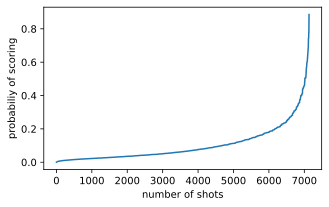

In [579]:
plot_predictions()

### Model Performance Evaluation

Model performance evaluation is implemented using ROC curve (for details see **A3.3 xG Model Evaluation with ROC**).

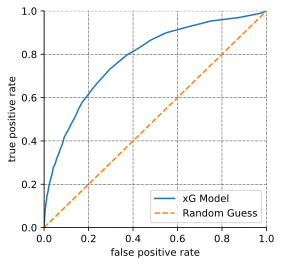

In [471]:
plot_roc()

In [62]:
# evaluate area under ROC curve using Python function roc_auc_score()
roc_auc_score(ndf['outcome'], ndf['xG'])

0.7843416803145005

We see that ROC value `0.784` is well above random guess (>> 0.5) which is an indicator of a satisfactory model performance.

## xT Equation Variables

In section 3, xT equation variables $s_{x, y}$, $m_{x, y}$, $xG_{x, y}$ were defined. Below you can see obtained results for each of these variables (see **A4. xT Equation Variables Derivation**).  

All of the results were obtained in the form of 12x16 matrix which was illustrated as a pitch heatmap.

### Probability Shooting $s_{x, y}$

This heatmap illustrates probability of shooting $s_{x, y}$ from a given (x, y). Naturally, as a player approaches an opponent's goal, $s_{x, y}$ increases.

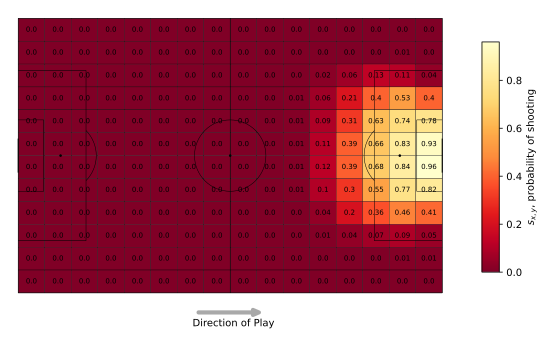

In [495]:
plot_shot_probs()

### Probability of Passing $m_{x, y}$

This heatmap illustrates probability of passing $m_{x, y}$ from a given (x, y). Naturally, as a player approaches an opponent's goal, $m_{x, y}$ decreases, since a player becomes more inclined to shooting.

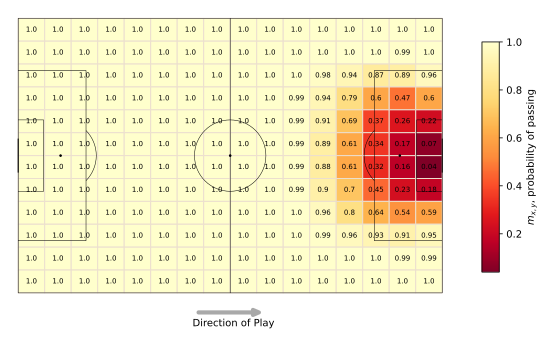

In [484]:
plot_pass_probs()

### Probability of Scoring  $xG_{x, y}$

This heatmap illustrates probability of scoring $xG_{x, y}$ from a given (x, y). Naturally, as a player approaches an opponent's goal, the distance to a goal decreases and the angle of a shot increases, thus, $xG_{x, y}$ increases.

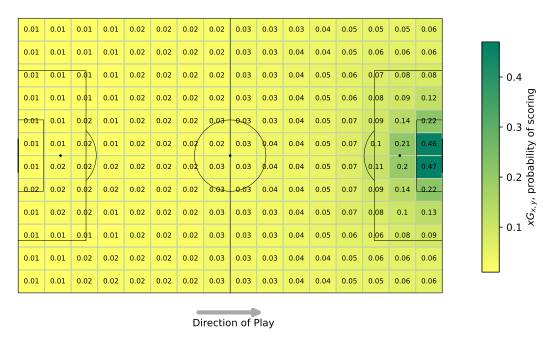

In [488]:
plot_score_probs()

### Transition Matrix $T_{x, y}$

Below you can see a function `transition_matrix()`that for a given (x, y) coordinate calculates a probability of passing to all other (x, y) coordinates (transition probabilities) and stores them inside a matrix.

In [496]:
def transition_matrix(x, y):
    # empty matrix for storing transition probabilities
    transition_matrix = np.zeros(shape = (12, 16))
    
    # from passes data frame filter out only passes with initial (x, y) equal to a given (x, y)
    transition_passes = passes[(passes["x_start_bin"] == x) & (passes["y_start_bin"] == y)]
    
    # iterate over all filtered passes and count passes with equal (x, y)
    for i in range(transition_passes.shape[0]):
        row_ind = transition_passes["y_end_bin"].iloc[i]
        col_ind = transition_passes["x_end_bin"].iloc[i]
        transition_matrix[row_ind, col_ind] = transition_matrix[row_ind, col_ind] + 1
    
    # divide counts for each (x, y) by the total number of passes to calculate probabilities
    transition_matrix = transition_matrix/transition_passes.shape[0]
    return transition_matrix

## xT Algorithm Implementation

Finally, using all the above estimated probabilities we can evaluate our xT values for all (x, y) coordinates of the pitch.

In [192]:
# xT algorithm
xT = np.zeros(shape = (12, 16))

# 5 iterations
for i in range(5):
    for x in range(16):
        for y in range(12):
            # evaluate transition matrix for a given (x, y)
            T_matrix = transition_matrix(x, y)
            
            # evaluate xT value for a given (x, y) using equation from section 3
            xT[y, x] = shot_probs[y, x] * score_probs[y, x] + pass_probs[y, x] * np.sum(T_matrix * xT)

# round and save results
it5 = pd.DataFrame(xT).round(decimals = 3)
#it5.to_csv('xT_grid.csv', index = False)    

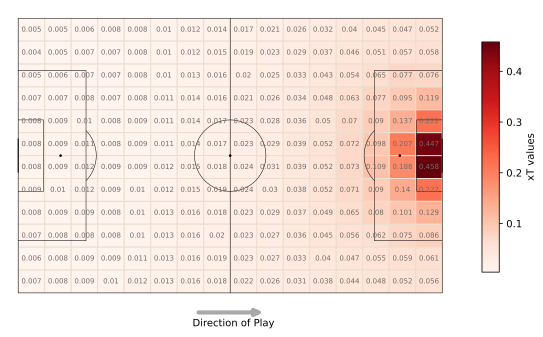

In [491]:
plot_xT()

## Results and Discussion

We make a sanity check of our model by comparing and plotting xT values of the players across **Bundesliga, EPL, LaLiga and Ligue 1** from 2017/2018 season using [Wyscout Soccer Match Event Dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000/2).

Barplots on the left illustrate xT values of top 10 players in the league. Barplots on the right illustrate xT values of top 10 young players among all league players aged under 21. Since the data is from 2017/2018 season, this allows us to track how the careers of young players actually developed given a single successful (according to xT) season.  

See **A5. Plot Functions** for the code for all plots in the following sections.

### Bundesliga

For Bundesliga, top 10 performers are mainly midfielders and defenders. Thiago Alcantara is well known as one of the most technically gifted players in the european football. He plays as the central midfielder, and, naturally, does not register a high number of goals and assists (2 league goals and 2 assists in 2017/2018) in his statistics. Nevertheless, he is the top performer in terms of xT per 90 equal to 0.56 according to our model (which means that, on average, his passes increase his team's probability of scoring by 0.56 per game). It makes sense to see Alcantara in the top 10 of our bar graph, since he is well known for a high ability to control the game in the central area and initiate attacks with line-breaking passes (the ones that may cut through and leave behind several players of opponent's team). There are also players similar to Alcantara's profile such as Nuri Sahin (2 goals, 2 assists), Charles Aranguiz (1 goal, 3 assists) who also found their place in our top 10. 

Central defenders also have a dominant presence in our xT bar graph. Given that they spend a large amount of time on field, in some scenarios, this can lead to a high number of aggregated small xT values. Thus, it is always important to normalize values per a single game ( per 90 minutes). Apart from that, modern central defenders should be capable of initiating their team's attacks with a great first pass (line-breaking pass, switch etc.). Players like Jerome Boateng and Mats Hummels are, in particular, appreciated for this kind of passes.

As stated previously, we can assess xT performance of young players and basing on a sinlge season success track their further career development. For example, Dayot Upamecano had a first breakthrough season in RB Leipzig (top of our xT bar graph) and after three more years of a consistent performance moved to Bayern Munich. During 2017/2018, Kai Havertz was already having his second full season in a senior football being 19 years old. He had two more successful seasons (29 goals, 9 assists) in Bayern Leverkusen and, then, moved to Chelsea. Panagiotis Retsos had a breakthrough season at Bayern Leverkusen as a right full back but suffered three serious injuries which kept him out of the game for the majority of the next season. This obivously had a serious impact on his career, and, so far, he struggled to regain his form during loan spells in England, France and Italy.

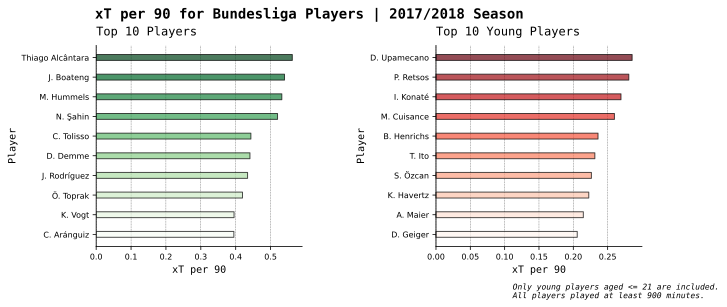

In [587]:
plot_bundesliga()

### EPL

In contrast with Bundesliga, top 10 EPL performers are mainly central and attacking midfielders and even a single wide playing forward. Starting from the latter, this is Alexis Sanchez, who made 74 shot creating passes in 2017/2018. In particular, he was also vital to his team for the ability to drop back into midfield and participate in the initiation of attacks.

The rest of top five (Cesc Fabregas, Kevin De Bruyne, Mesut Ozil, David Silva) are creative forces of their teams (0.70, 0.59, 0.57, 0.54 xT per 90). All four were generating the chances of at least a half goal per a game, and this does not even include the rest of their advaced statistics such as xG or xA. The bottom top five consists of more functional central midfielders (except attacking Phillipe Coutinho) whose xT values are close or slightly higher that 0.5. In other words, we observe that xT metric validates importance of these players for their teams.

When having a look at the performance of young players, we can observe a rise of full backs such as Trent Alexander-Arnold, Ainsley Maitland-Niles, Timothy Fosu-Mensah and Ben Chilwell. Alexander-Arnold (0.32 xT per 90) is regarded one of the top performing full backs of the last three seasons (9 goals, 44 assists). He is known for his ability to initiate the attacks from the right half-space. As with senior players, we observe functional midfielders such as Wilfred Ndidi and Declan Rice in the bottom five of our bar graph. Being recognized for their defensive skills, these players are regular starters of their teams despite their young age. 

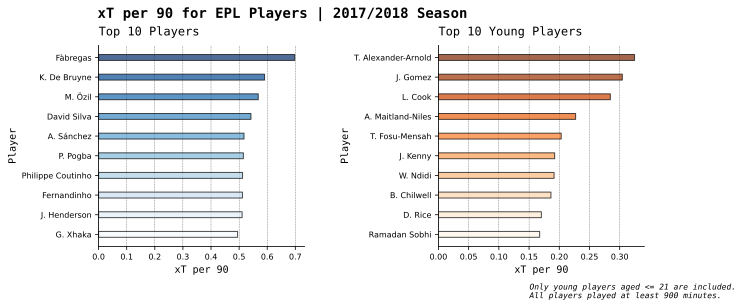

In [599]:
plot_epl()

### LaLiga

Similar to EPL, we mainly observe central and attacking midfielders among top 10 performers in LaLiga. However, one name stands out here, and that is Lionel Messi. Messi is known for his skills to drop deeper, participate in the game play in the central area and, then, run forward. This is one of the reasons why he managed to aggregate 0.59 xT per 90. Andres Iniesta and Ever Banega also have identical to Messi's xT results and are an essential part of their teams during the possession. It is also interesting to see a left full back Marcelo with his 0.5 xT per 90. Though mainly playing from the left, he possess great passing skills which help to build and progress his team's attacks.

LaLiga's top young players play in various positions from wingers and central midfielders to full backs and central defenders. Despite being largerly hit by injuries, Ousmane Dembele were able to demonstrate his potential with 0.28 xT per 90 in his first season for Barcelona. However, injuries still haunted him in the following seasons which, obviously, affected his career. Theo Hernandez impressed for Real Madrid as a left full back (0.22 xT per 90), despite a limited time, and, in the last three seasons, were a stable starting eleven player for Milan. Federico Valverde had a great season as a box-to-box midfielder (0.25 xT per 90) in his first season for Deportivo La Coruna, and, afterwards, earned his place in Real Madrid. 

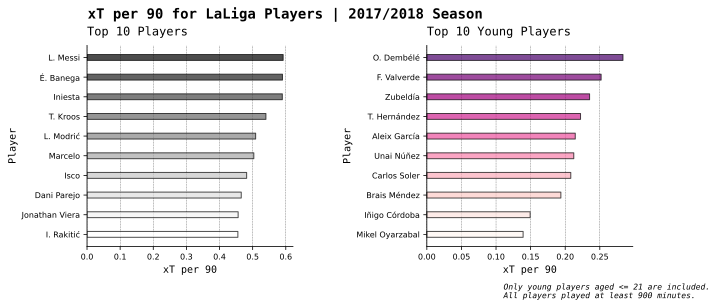

In [600]:
plot_laliga()

### Ligue 1

When evaluating top 10 players from Ligue 1, we observe similar patterns as in LaLiga. The first place is reserved by Neymar with 0.62 xT per 90 who plays as a wide forward or attacking midfielder. There are also several deep-lying midfielders such as Marco Veratti, Yann M'vila, Thiago Motta and Jean Seri. Similar to Marcelo from LaLiga, Daniel Alves is the only full back in the list. Daniel Alves who operates from the right wing has always been a creative and technical player with great passing and ball progressing skills. In any of the teams in which he played, he has been instrumental to holding possession and movement of a ball to high threating areas.

Maxime Lopez is the only player, out of four leagues that were reviewed, who earned his place in both senior and young players list with 0.51 xT per 90. Despite his young age of 19, 2017/2018 season was already his second season in senior football where he helped Marseille to achieve the fourth place in the league. He continued playing as a midfielder three more years for the french club but had a limited time in the last season. Thus, he was loaned to the italian team Sassuolo. Despite playing regularly there, he could not convince Marseille to bring him back and, eventually, stayed in Italy on the permanent basis.

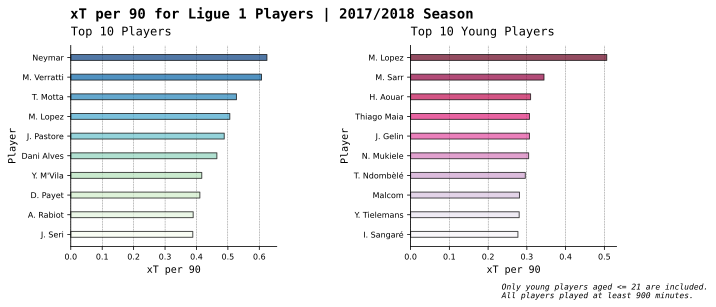

In [601]:
plot_ligue1()

## Conclusion

As it can be seen from the above results, xT Model demonstrates a good performance when trying to evaluate players who are overlooked by traditional or shot-oriented advanced statistics but are still important to their teams. These can be different types of players such as central defenders with a great first pass, deep-lying midfielders switching game with long ranging passes and creative full backs involved in possession. However, as it stands for all models, this model also has a room for improvement. 

Below are suggestions for further studies of xT model:
- add other action types such as carries and take-ons
- account for actions with negative xT such as inaccurate passes or lost balls
- use negative xT during player performance evaluation
- normalize xT results per number of actions by a player

## References

* *[Karun Singh's](https://karun.in/blog/expected-threat.html) Expected Threat Model, 2019.* 

* *Roy, Maaike Van, Pieter Robberechts, Tom Decroos and Jesse Davis. [“Valuing On-the-Ball Actions in Soccer: A Critical Comparison of xT and VAEP.”](https://tomdecroos.github.io/reports/xt_vs_vaep.pdf) (2020).*

* *Jim Albert and Jingchen Hu, [Probability and Bayesian Modelling](https://bayesball.github.io/BOOK/simulation-by-markov-chain-monte-carlo.html#markov-chains), Ch. 9.2, Markov Chains, 2019.*

* *[Wyscout Soccer Match Event Dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000/2), 2019.*

## Appendix

### A1. Libraries

In [66]:
# import required libraries
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import matplotlib_inline
from matplotlib import cm

### A2. Event Data Preprocessing

In [41]:
# import public wyscout data loader from socceraction library
from socceraction.data.wyscout import PublicWyscoutLoader 

# load public wyscout data
wyscout_data = PublicWyscoutLoader()

# import tags for uncode subevents in event data
tags = pd.read_csv('wyscout_tags.csv', sep = ';')

# make all descriptions lowercase
tags['Description'] = tags['Description'].str.lower()

# transform tags data frame into dictionary
tags = dict(zip(tags['Tag'], tags['Description']))

In [ ]:
# England 17/18, competition_id = 364, season_id = 181150
epl_games = wyscout_data.games(competition_id = 364, season_id = 181150)["game_id"]


##################################################################################################
# Below sections were executed a single time and saved as .csv files (only comment out if needed)#
##################################################################################################
# Section 1.
# convert all premier league matches to SPADL format and save as .csv files
#for i in epl_games:
#    df = wyscout_data.events(i)
#    df.to_csv(f'epl_games/{i}.csv')

###################################################################################################
# Section 2.
# concate all .csv files aka 'game ids' into a single data frame and save events.csv

# list of all game ids
#files = os.listdir('epl_games/.')

#events = pd.DataFrame()
#for i in files:
#    df = pd.read_csv(f'epl_games/{i}')
#    events = pd.concat([events, df])
#events.to_csv(f'events.csv', index = False)    

## This code refines all events for the specific task

# upload 'events' data frame that includes events of all 380 EPL games
df = pd.read_csv('events.csv')

# create column indices to be removed
rm_col_ind = np.r_[0:6]
df = df.drop(columns = df.columns[rm_col_ind])

# convert strings into python lists
df['tags'] = df['tags'].apply(ast.literal_eval)
df['positions'] = df['positions'].apply(ast.literal_eval)

# make 'type_name' and 'subtype_name' columns lowercase 
df['type_name'] = df['type_name'].str.lower()
df['subtype_name'] = df['subtype_name'].str.lower()

# create separate initial(start) and final(end) coordinates from 'positions' column
# if action has only 'start' coordinates set 'end' coordinates to 'nan'
df['x_start'] = df['positions'].apply(lambda x: x[0]['x'])
df['y_start'] = df['positions'].apply(lambda x: x[0]['y'])
df['x_end'] = df['positions'].apply(lambda x: x[1]['x'] if len(x) == 2 else np.nan)
df['y_end'] = df['positions'].apply(lambda x: x[1]['y'] if len(x) == 2  else np.nan)

# use dictionaries and list comprehensions to convert tags into tag ids and their descriptions 
df['tag_id'] = df['tags'].apply(lambda x: [value for d in x for value in d.values()])
df['tag_name'] = df['tag_id'].apply(lambda x: [tags[i] for i in x])


# drop redundant column 'positions'
df.drop(columns = ['positions', 'tags'], inplace=True)

# rearrange columns
rearr_cols = np.r_[0:5, 9, 10, 5:9]
df = df.iloc[:, rearr_cols]

# save 'df' as 'refined_events.csv' data frame
df.to_csv('refined_events.csv', index = False)    

### A3. xG Model

#### A3.1 Filter Shots

In [ ]:
df = pd.read_csv('epl/refined_events.csv')
df['tag_id'] = df['tag_id'].apply(ast.literal_eval)
df['tag_name'] = df['tag_name'].apply(ast.literal_eval)


# free kicks are not included (penalties are also part of free kicks)
shots = df[df['type_name'] == 'shot']

# function for removing headers
def headers_out(x):
    for i in x:
        if i == 403:
            return False
            break
    else:
        return True

# function for assigning shot outcomes as '1' or '0' (goal or no goal)
def goals(x):
    for i in x:
        if i == 101:
            return 1
            break
    else:
        return 0

# remove headers from shots
non_headers = shots['tag_id'].apply(lambda x: headers_out(x))
shots = shots[non_headers]
# assign outcome to each shot
outcome = shots['tag_id'].apply(lambda x: goals(x))
shots['outcome'] = outcome

shots.to_csv('epl/shots.csv', index = False)    

In [44]:
shots = pd.read_csv('epl/shots.csv')

#### A3.2 Feature Generating Function

In [ ]:
# Generate 'Angle' and 'Distance' features from x,y coordinates provided as a new input to our xG model

def generate_features(coords):
    
    # unpack tuple
    x = coords[0]
    y = coords[1]
    
    # Distance Feature calculation
    # define goal center for 'wyscout' data
    goal_center = np.array([100, 50])

    # calculate distance between shot and goal center
    distance = np.sqrt((x - goal_center[0])**2 + (y - goal_center[1])**2)
    distance = distance.round(decimals = 2)


    # Angle Feature calculation
    # transform x, y coordinates from percentiles to field length coordinates (105 meters x 68 meters)
    x = x * 105/100
    y = y * 68/100 

    # Use trigonometric formula to find angle between two sides (a,b ) of triangle where third side c is a goal line of length 7.32
    a = np.sqrt((x - 105)**2 + (y - 30.34)**2) # length between right post and x,y shot coordinate
    b = np.sqrt((x - 105)**2 + (y - 37.66)**2) # length between left post and x,y shot coordinate
    c = 7.32 # goal line length
    cos_alpha = (a**2 + b**2 - c**2)/(2*a*b)
    cos_alpha = np.round(cos_alpha, decimals = 4)

    # remember to leave angle in radians (if you want to transfer to degree multiply cos_alpha by 180/pi)
    angle = np.arccos(cos_alpha).round(decimals = 2)
    # return 'distance' and 'angle' features as numpy array
    return np.array([distance, angle])

#### A3.3 xG Model Evaluation with ROC

In [578]:
def plot_predictions():
    plt.figure(figsize = (5, 3))
    plt.plot(sorted(predictions))
    plt.xlabel('number of shots')
    plt.ylabel('probabiliy of scoring')
    plt.show()

In [60]:
ndf = pd.concat([features, labels], axis = 1)
ndf = ndf.reset_index()
ndf.drop("index", axis = 1, inplace=True)
ndf["xG"] = xG_model.predict_proba(features)[:, 1]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# define range for threshold value
n = 100
  
# create row for checking each value with 'r' threshold values
ndf['sim_outcome'] = np.zeros(shape = (ndf.shape[0], 1))
# create container matrix for FPR and TPR
roc_matrix = np.zeros(shape = (100, 3))
# 'r' threshold values for probability 
thresholds = np.arange(0, 1, 1/n)
# save threshold values as the first row
roc_matrix[:, 0] = thresholds

for i, m in enumerate(thresholds):
    ndf['sim_outcome'] = ndf['xG'].apply(lambda x: 1 if x > m else 0)
    TN, FP, FN, TP = confusion_matrix(ndf['outcome'], ndf['sim_outcome']).ravel()
    roc_matrix[i, 1] = FP/(TN + FP) # false positive rate
    roc_matrix[i, 2] = TP/(TP + FN) # true positive rate

# plot ROC curve
def plot_roc():
    fig, ax = plt.subplots(figsize = (4, 4))
    ax.grid(color='black', ls = '-.', lw = 0.4, which = 'major')
    ax.plot(roc_matrix[:, 1], roc_matrix[:, 2], zorder = 2)
    ax.plot([0, 1], [0, 1], ls = '--')
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(labels = ['xG Model', 'Random Guess'], loc = 4,
              #bbox_to_anchor=(1.0, 0.1, 0.5, 0.5),
             frameon = True)
    plt.show()

### A4. xT Equation Variables Derivation

#### A4.1 Shooting Probability 

In [64]:
x_intervals = np.linspace(0, 100, 17)
y_intervals = np.linspace(0, 100, 13)

shots["x_start_bin"] = pd.cut(shots["x_start"], bins = x_intervals, include_lowest=True, labels = False)
shots["y_start_bin"] = pd.cut(shots["y_start"], bins = y_intervals, include_lowest=True, labels = False)

shots["x_end_bin"] = pd.cut(shots["x_end"], bins = x_intervals, include_lowest=True, labels = False)
shots["y_end_bin"] = pd.cut(shots["y_end"], bins = y_intervals, include_lowest=True, labels = False)

shot_counts = np.zeros(shape = (12, 16))
for i in range(shots.shape[0]):
    row_ind = shots["y_start_bin"].iloc[i]
    col_ind = shots["x_start_bin"].iloc[i]
    shot_counts[row_ind, col_ind] = shot_counts[row_ind, col_ind] + 1

#### A4.2 Passing Probability

In [67]:
df = pd.read_csv('epl/refined_events.csv')
df['tag_id'] = df['tag_id'].apply(ast.literal_eval)
df['tag_name'] = df['tag_name'].apply(ast.literal_eval)

In [ ]:
# free kicks are not included (penalties are also part of free kicks)
passes = df[df['type_name'] == 'pass']

passes["x_start_bin"] = pd.cut(passes["x_start"], bins = x_intervals, include_lowest=True, labels = False)
passes["y_start_bin"] = pd.cut(passes["y_start"], bins = y_intervals, include_lowest=True, labels = False)

passes["x_end_bin"] = pd.cut(passes["x_end"], bins = x_intervals, include_lowest=True, labels = False)
passes["y_end_bin"] = pd.cut(passes["y_end"], bins = y_intervals, include_lowest=True, labels = False)

# save accurate passes as .csv file
passes.to_csv('epl_passes.csv', index = False)      

In [68]:
passes = pd.read_csv('epl/epl_passes.csv')

pass_counts = np.zeros(shape = (12, 16))
for i in range(passes.shape[0]):
    row_ind = passes["y_start_bin"].iloc[i]
    col_ind = passes["x_start_bin"].iloc[i]
    pass_counts[row_ind, col_ind] = pass_counts[row_ind, col_ind] + 1


In [ ]:
# pass probabilities
pass_probs = pass_counts/(pass_counts + shot_counts)
# shot probabilities
shot_probs = shot_counts/(pass_counts + shot_counts)

#### A4.3 Scoring Probability

In [74]:
x_grid = np.linspace(0, 100, 160)
y_grid = np.linspace(0, 100, 120)

# scoring probability for 
xG_values = np.zeros(shape = (120, 160))
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        #print(i, j)
        k = x_grid[i], y_grid[j]
        f1 = generate_features(k)
        xG_values[j, i] = xG_model.predict_proba(f1.reshape(1, -1))[:, 1]
        
# 12 x 16 grid without averaging
unrefined_xg = pd.DataFrame(xG_values)

refined_xg = np.zeros(shape = (12, 16))
x_len = xG_values.shape[1] + 1
y_len = xG_values.shape[0] + 1

row_ind = 0
for j in range(10, y_len, 10):
    col_ind = 0
    for i in range(10, x_len, 10):
        avg_result = unrefined_xg.iloc[(j - 10):j, (i - 10):i].values.mean()
        refined_xg[row_ind, col_ind] = avg_result
        col_ind = col_ind + 1
    row_ind = row_ind + 1

# scoring probabilities derived from xG model
score_probs = refined_xg.round(decimals = 2)

### A5. Plot Functions

#### A5.1 xT values Grid

In [489]:
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

def plot_xT():

    # import xT values as .csv file
    xT_grid = pd.read_csv('xT_grid.csv')

    # transform xT grid into a shap
    xT_transform = np.zeros(shape = (192, 3))
    count = 0
    for i, y in xT_grid.iterrows():
        for j, x in xT_grid.iteritems():
            xT_transform[count, :] = np.array([i, j, xT_grid.iloc[int(i), int(j)]])
            count = count + 1
    xT_transform = pd.DataFrame(xT_transform)
    xT_transform.reset_index(drop = True, inplace = True)
    xT_transform.columns = ['x', 'y', 'value']


    # Canvas
    fig, ax = plt.subplots(figsize = (8, 8))

    # Heatmap
    pitch = Pitch(pitch_type='wyscout', line_zorder=1,
                  pitch_color='white', line_color='black', linewidth = 0.5)

    pitch.draw(ax = ax)
    bin_statistic = pitch.bin_statistic(xT_transform.x, xT_transform.y, statistic='count', bins=(16, 12))
    bin_statistic['statistic'] = xT_grid.to_numpy()
    pt = pitch.heatmap(bin_statistic, ax = ax, cmap='Reds', edgecolor = '#EBDECE')
    pitch.label_heatmap(bin_statistic, color='#736B65', fontsize=7, ax = ax, ha='center', va='center', zorder = 2)


    # Arrow 
    arrow_ax = fig.add_axes([0.30, 0.20, 0.35, 0.3]) # X, Y, width, height

    arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
               color='darkgrey', length_includes_head=True)
    arrow_ax.set_ylim(0, 1)
    arrow_ax.set_xlim(0, 1)
    arrow_ax.set_axis_off()
    arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


    # Colorbar
    ax_cbar = fig.add_axes((0.95, 0.3, 0.03, 0.4))
    fig.colorbar(pt, cax = ax_cbar).set_label(label = 'xT values', size=10)

    #
    plt.show()

#### A5.2 Passing Probability

In [483]:
def plot_pass_probs():

    # import probability of passing as .csv file
    xT_grid = pd.DataFrame(pass_probs.round(decimals = 2))

    # transform xT grid into a shap
    xT_transform = np.zeros(shape = (192, 3))
    count = 0
    for i, y in xT_grid.iterrows():
        for j, x in xT_grid.iteritems():
            xT_transform[count, :] = np.array([i, j, xT_grid.iloc[int(i), int(j)]])
            count = count + 1
    xT_transform = pd.DataFrame(xT_transform)
    xT_transform.reset_index(drop = True, inplace = True)
    xT_transform.columns = ['x', 'y', 'value']


    # Canvas
    fig, ax = plt.subplots(figsize = (8, 8))

    # Heatmap
    pitch = Pitch(pitch_type='wyscout', line_zorder=1,
                  pitch_color='white', line_color='black', linewidth = 0.5)
    
    # getting the original colormap using cm.get_cmap() function
    orig_map=plt.cm.get_cmap('YlOrRd')
  
    # reversing the original colormap using reversed() function
    reversed_map = orig_map.reversed()

    pitch.draw(ax = ax)
    bin_statistic = pitch.bin_statistic(xT_transform.x, xT_transform.y, statistic='count', bins=(16, 12))
    bin_statistic['statistic'] = xT_grid.to_numpy()
    pt = pitch.heatmap(bin_statistic, ax = ax, cmap = reversed_map, edgecolor = '#EBDECE')
    pitch.label_heatmap(bin_statistic, color='black', fontsize=7, ax = ax, ha='center', va='center', zorder = 2)


    # Arrow 
    arrow_ax = fig.add_axes([0.30, 0.20, 0.35, 0.3]) # X, Y, width, height

    arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
               color='darkgrey', length_includes_head=True)
    arrow_ax.set_ylim(0, 1)
    arrow_ax.set_xlim(0, 1)
    arrow_ax.set_axis_off()
    arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


    # Colorbar
    ax_cbar = fig.add_axes((0.95, 0.3, 0.03, 0.4))
    fig.colorbar(pt, cax = ax_cbar).set_label(label = '$m_{x, y}$, probability of passing', size=10)

    #
    plt.show()

#### A5.3 Shooting Probability

In [494]:
def plot_shot_probs():

    # import probability of shooting as .csv file
    xT_grid = pd.DataFrame(shot_probs.round(decimals = 2))

    # transform xT grid into a shap
    xT_transform = np.zeros(shape = (192, 3))
    count = 0
    for i, y in xT_grid.iterrows():
        for j, x in xT_grid.iteritems():
            xT_transform[count, :] = np.array([i, j, xT_grid.iloc[int(i), int(j)]])
            count = count + 1
    xT_transform = pd.DataFrame(xT_transform)
    xT_transform.reset_index(drop = True, inplace = True)
    xT_transform.columns = ['x', 'y', 'value']


    # Canvas
    fig, ax = plt.subplots(figsize = (8, 8))

    # Heatmap
    pitch = Pitch(pitch_type='wyscout', line_zorder=1,
                  pitch_color='white', line_color='black', linewidth = 0.5)
    
    # getting the original colormap using cm.get_cmap() function
    orig_map=plt.cm.get_cmap('YlOrRd')
  
    # reversing the original colormap using reversed() function
    reversed_map = orig_map.reversed()

    pitch.draw(ax = ax)
    bin_statistic = pitch.bin_statistic(xT_transform.x, xT_transform.y, statistic='count', bins=(16, 12))
    bin_statistic['statistic'] = xT_grid.to_numpy()
    pt = pitch.heatmap(bin_statistic, ax = ax, cmap = reversed_map, edgecolor = 'black', linewidth = 0.3)
    pitch.label_heatmap(bin_statistic, color='black', fontsize=7, ax = ax, ha='center', va='center', zorder = 2)


    # Arrow 
    arrow_ax = fig.add_axes([0.30, 0.20, 0.35, 0.3]) # X, Y, width, height

    arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
               color='darkgrey', length_includes_head=True)
    arrow_ax.set_ylim(0, 1)
    arrow_ax.set_xlim(0, 1)
    arrow_ax.set_axis_off()
    arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


    # Colorbar
    ax_cbar = fig.add_axes((0.95, 0.3, 0.03, 0.4))
    fig.colorbar(pt, cax = ax_cbar).set_label(label = '$s_{x, y}$, probability of shooting', size=10)

    #
    plt.show()

#### A5.4 Scoring Probability

In [486]:
def plot_score_probs():

    # import probability of scoring as .csv file
    xT_grid = pd.DataFrame(score_probs.round(decimals = 2))

    # transform xT grid into a shap
    xT_transform = np.zeros(shape = (192, 3))
    count = 0
    for i, y in xT_grid.iterrows():
        for j, x in xT_grid.iteritems():
            xT_transform[count, :] = np.array([i, j, xT_grid.iloc[int(i), int(j)]])
            count = count + 1
    xT_transform = pd.DataFrame(xT_transform)
    xT_transform.reset_index(drop = True, inplace = True)
    xT_transform.columns = ['x', 'y', 'value']


    # Canvas
    fig, ax = plt.subplots(figsize = (8, 8))

    # Heatmap
    pitch = Pitch(pitch_type='wyscout', line_zorder=1,
                  pitch_color='white', line_color='black', linewidth = 0.5)
    
    # getting the original colormap using cm.get_cmap() function
    orig_map=plt.cm.get_cmap('summer')
  
    # reversing the original colormap using reversed() function
    reversed_map = orig_map.reversed()

    pitch.draw(ax = ax)
    bin_statistic = pitch.bin_statistic(xT_transform.x, xT_transform.y, statistic='count', bins=(16, 12))
    bin_statistic['statistic'] = xT_grid.to_numpy()
    pt = pitch.heatmap(bin_statistic, ax = ax, cmap = reversed_map, edgecolor = '#C3D2A3')
    pitch.label_heatmap(bin_statistic, color='black', fontsize=7, ax = ax, ha='center', va='center', zorder = 2)


    # Arrow 
    arrow_ax = fig.add_axes([0.30, 0.20, 0.35, 0.3]) # X, Y, width, height

    arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
               color='darkgrey', length_includes_head=True)
    arrow_ax.set_ylim(0, 1)
    arrow_ax.set_xlim(0, 1)
    arrow_ax.set_axis_off()
    arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


    # Colorbar
    ax_cbar = fig.add_axes((0.95, 0.3, 0.03, 0.4))
    fig.colorbar(pt, cax = ax_cbar).set_label(label = '$xG_{x, y}$, probability of scoring', size=10)

    #
    plt.show()

####  A5.5 xT values for Bundesliga Players

In [586]:
def plot_bundesliga():

    # import Bundesliga xT results
    bl10 = pd.read_csv("bundesliga/top10_players.csv").sort_values(by = 'xt_per_90', ascending = True)
    bly10 = pd.read_csv("bundesliga/top10_young_players.csv").sort_values(by = 'xt_per_90', ascending = True)

    # check how colormap looks
    cm.get_cmap('Blues', 4)

    # For LinearSegmented use (no 'colors' attribute):
    colors = cm.get_cmap('Greens', 10)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4, 4))

    ax[0].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[0].barh(bl10["nickname"], bl10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    font = {'family': 'monospace',
            'weight': 'normal',
            'size': 12,
            }

    font2 = {'family': 'monospace',
            'weight': 'normal',
            'size': 10,
            }

    ax[0].set_ylabel("Player", fontdict = font2)
    ax[0].tick_params(axis='both', which='major', labelsize = 8)
    ax[0].set_xlabel("xT per 90", fontdict = font2)
    ax[0].set_title("Top 10 Players", loc = "left", pad = 10, fontdict = font)
    ax[0].spines[['top', 'right']].set_visible(False)

    #############################################################################################
    #############################################################################################

    colors = cm.get_cmap('Reds', 10)

    ax[1].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[1].barh(bly10["nickname"], bly10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    ax[1].set_ylabel("Player", fontdict = font2)
    ax[1].tick_params(axis='both', which='major', labelsize = 8)
    ax[1].set_xlabel("xT per 90", fontdict = font2)
    ax[1].set_title("Top 10 Young Players", loc = "left", pad = 10, fontdict = font)
    ax[1].spines[['top', 'right']].set_visible(False)



    # set the spacing between subplots
    plt.subplots_adjust(left = 0.1,
                        bottom = 1.3, 
                        right = 2, 
                        top = 2, 
                        wspace = 0.65, 
                        hspace = 0.5)

    font3 = {'family': 'monospace',
            'weight': 'bold',
            'size': 14
            }

    font4 = {'family': 'monospace',
            'style': 'italic',
            'size': 8,
            }

    fig.suptitle('xT per 90 for Bundesliga Players | 2017/2018 Season', x = 0.842, y = 2.133, fontproperties = font3)
    fig.text(x = 1.55, y = 1.15, s = "Only young players aged <= 21 are included.", fontdict = font4)
    fig.text(x = 1.55, y = 1.12, s = "All players played at least 900 minutes.", fontdict = font4)


    plt.show()

####  A5.6 xT values for EPL Players

In [595]:
def plot_epl():
    
    # import EPL xT results
    epl10 = pd.read_csv("epl/top10_players.csv").sort_values(by = 'xt_per_90', ascending = True)
    eply10 = pd.read_csv("epl/top10_young_players.csv").sort_values(by = 'xt_per_90', ascending = True)

    # check how colormap looks
    cm.get_cmap('Blues', 4)

    # For LinearSegmented use (no 'colors' attribute):
    colors = cm.get_cmap('Blues', 10)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4, 4))

    ax[0].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[0].barh(epl10["nickname"], epl10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    font = {'family': 'monospace',
            'weight': 'normal',
            'size': 12,
            }

    font2 = {'family': 'monospace',
            'weight': 'normal',
            'size': 10,
            }

    ax[0].set_xlabel("xT per 90", fontdict = font2)
    ax[0].set_ylabel("Player", fontdict = font2)
    ax[0].tick_params(axis='both', which='major', labelsize = 8)
    ax[0].set_title("Top 10 Players", loc = "left", pad = 10, fontdict = font)
    ax[0].spines[['top', 'right']].set_visible(False)

    #############################################################################################
    #############################################################################################

    colors = cm.get_cmap('Oranges', 10)

    ax[1].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[1].barh(eply10["nickname"], eply10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    ax[1].set_xlabel("xT per 90", fontdict = font2)
    ax[1].set_ylabel("Player", fontdict = font2)
    ax[1].tick_params(axis='both', which='major', labelsize = 8)
    ax[1].set_title("Top 10 Young Players", loc = "left", pad = 10, fontdict = font)
    ax[1].spines[['top', 'right']].set_visible(False)



    # set the spacing between subplots
    plt.subplots_adjust(left = 0.1,
                        bottom = 1.3, 
                        right = 2, 
                        top = 2, 
                        wspace = 0.65, 
                        hspace = 0.5)

    font3 = {'family': 'monospace',
            'weight': 'bold',
            'size': 14
            }

    font4 = {'family': 'monospace',
            'style': 'italic',
            'size': 8,
            }

    fig.suptitle('xT per 90 for EPL Players | 2017/2018 Season', x = 0.74, y = 2.133, fontproperties = font3)
    fig.text(x = 1.6, y = 1.15, s = "Only young players aged <= 21 are included.", fontdict = font4)
    fig.text(x = 1.6, y = 1.12, s = "All players played at least 900 minutes.", fontdict = font4)


    plt.show()

####  A5.7 xT values for LaLiga Players

In [596]:
def plot_laliga():
    
    # import LaLiga xT results
    ll10 = pd.read_csv("laliga/top10_players.csv").sort_values(by = 'xt_per_90', ascending = True)
    lly10 = pd.read_csv("laliga/top10_young_players.csv").sort_values(by = 'xt_per_90', ascending = True)

    # For LinearSegmented use (no 'colors' attribute):
    colors = cm.get_cmap('Greys', 10)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4, 4))

    ax[0].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[0].barh(ll10["nickname"], ll10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    font = {'family': 'monospace',
            'weight': 'normal',
            'size': 12,
            }

    font2 = {'family': 'monospace',
            'weight': 'normal',
            'size': 10,
            }

    ax[0].set_ylabel("Player", fontdict = font2)
    ax[0].set_xlabel("xT per 90", fontdict = font2)
    ax[0].tick_params(axis='both', which='major', labelsize = 8)
    ax[0].set_title("Top 10 Players", loc = "left", pad = 10, fontdict = font)
    ax[0].spines[['top', 'right']].set_visible(False)

    #############################################################################################
    #############################################################################################

    colors = cm.get_cmap('RdPu', 10)

    ax[1].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[1].barh(lly10["nickname"], lly10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    ax[1].set_ylabel("Player", fontdict = font2)
    ax[1].set_xlabel("xT per 90", fontdict = font2)
    ax[1].tick_params(axis='both', which='major', labelsize = 8)
    ax[1].set_title("Top 10 Young Players", loc = "left", pad = 10, fontdict = font)
    ax[1].spines[['top', 'right']].set_visible(False)



    # set the spacing between subplots
    plt.subplots_adjust(left = 0.1,
                        bottom = 1.3, 
                        right = 2, 
                        top = 2, 
                        wspace = 0.65, 
                        hspace = 0.5)

    font3 = {'family': 'monospace',
            'weight': 'bold',
            'size': 14
            }

    font4 = {'family': 'monospace',
            'style': 'italic',
            'size': 8,
            }

    fig.suptitle('xT per 90 for LaLiga Players | 2017/2018 Season', x = 0.79, y = 2.133, fontproperties = font3)
    fig.text(x = 1.55, y = 1.15, s = "Only young players aged <= 21 are included.", fontdict = font4)
    fig.text(x = 1.55, y = 1.12, s = "All players played at least 900 minutes.", fontdict = font4)


    plt.show()

####  A5.8 xT values for Ligue 1 Players

In [598]:
def plot_ligue1():
    
    # import Ligue 1 xT results
    l10 = pd.read_csv("ligue1/top10_players.csv").sort_values(by = 'xt_per_90', ascending = True)
    ly10 = pd.read_csv("ligue1/top10_young_players.csv").sort_values(by = 'xt_per_90', ascending = True)

    # For LinearSegmented use (no 'colors' attribute):
    colors = cm.get_cmap('GnBu', 10)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4, 4))

    ax[0].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[0].barh(l10["nickname"], l10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    font = {'family': 'monospace',
            'weight': 'normal',
            'size': 12,
            }

    font2 = {'family': 'monospace',
            'weight': 'normal',
            'size': 10,
            }

    ax[0].set_ylabel("Player", fontdict = font2)
    ax[0].set_xlabel("xT per 90", fontdict = font2)
    ax[0].tick_params(axis='both', which='major', labelsize = 8)
    ax[0].set_title("Top 10 Players", loc = "left", pad = 10, fontdict = font)
    ax[0].spines[['top', 'right']].set_visible(False)

    #############################################################################################
    #############################################################################################

    colors = cm.get_cmap('PuRd', 10)

    ax[1].grid(color='black', ls = '-.', lw = 0.25, axis = "x")
    ax[1].barh(ly10["nickname"], ly10["xt_per_90"], height = 0.3,
           color = colors(range(10)), edgecolor = "black", zorder = 2, alpha = 0.7) 

    ax[1].set_ylabel("Player", fontdict = font2)
    ax[1].set_xlabel("xT per 90", fontdict = font2)
    ax[1].tick_params(axis='both', which='major', labelsize = 8)
    ax[1].set_title("Top 10 Young Players", loc = "left", pad = 10, fontdict = font)
    ax[1].spines[['top', 'right']].set_visible(False)



    # set the spacing between subplots
    plt.subplots_adjust(left = 0.1,
                        bottom = 1.3, 
                        right = 2, 
                        top = 2, 
                        wspace = 0.65, 
                        hspace = 0.5)

    font3 = {'family': 'monospace',
            'weight': 'bold',
            'size': 14
            }

    font4 = {'family': 'monospace',
            'style': 'italic',
            'size': 8,
            }

    fig.suptitle('xT per 90 for Ligue 1 Players | 2017/2018 Season', x = 0.8, y = 2.133, fontproperties = font3)
    fig.text(x = 1.6, y = 1.15, s = "Only young players aged <= 21 are included.", fontdict = font4)
    fig.text(x = 1.6, y = 1.12, s = "All players played at least 900 minutes.", fontdict = font4)


    plt.show()